In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import os
import numpy as np
from pathlib import Path
import yaml

PROJECT_ROOT = Path(os.getcwd()).parent

with open(PROJECT_ROOT/"config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
print(config)

{'paths': {'raw_data_dir': 'data/raw', 'scanned_data_dir': 'data/scanned', 'processed_data_dir': 'data/processed', 'dataset_name': 'hanzi_dataset', 'checkpoint_dir': 'checkpoints'}, 'processing': {'source_img': 'sheet2.jpg', 'scanned_img': 'sheet2_scan.jpg', 'iters': 2, 'target_height': 32, 'target_width': 32, 'grayscale': True}, 'classes': {'names': ['I', 'YOU', 'HE', 'WATER', 'HORSE', 'FEMALE', 'WRITE']}, 'training': {'model_name': 'hanzi_conv', 'in_size': 32, 'in_channels': 1, 'kernel_size': 3, 'batch_size': 32, 'learning_rate': 0.001, 'max_epochs': 200, 'eval_interval': 5, 'seed': 42, 'device': 'cuda'}}


#### Define Dataset Transformations

In [2]:

image_transforms = transforms.Compose([

    # 1. Ensure grayscale (1 channel)
    transforms.Grayscale(num_output_channels=1), 
    
    # 2. Scale to [0.0, 1.0]; Change shape to [C, H, W])
    transforms.ToTensor(), 
    
    # 3. Normalization
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

#### Load the dataset

In [13]:
processed_data_dir = config['paths']['processed_data_dir']
dataset_name = config['paths']['dataset_name']

dataset_path = PROJECT_ROOT / processed_data_dir / dataset_name
dataset_train_path = dataset_path / "train"
dataset_val_path = dataset_path / "val"

dataset_train = torchvision.datasets.ImageFolder(root=dataset_train_path, transform=image_transforms)
dataset_val = torchvision.datasets.ImageFolder(root=dataset_val_path, transform=image_transforms)

dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=2)
dataloader_val = torch.utils.data.DataLoader(dataset_val, shuffle=True, batch_size=2)





#### Create Model

##### Simple Convolutional Network
Formula to calculate kernel size:
$$O = \lfloor \frac{W - K + 2P}{S} \rfloor + 1$$


In [16]:
class HanziConv(nn.Module):
    def __init__(self, in_size, n_classes, in_channels=1, kernel_size=3): # 32x32x1
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # 1. Layer
            nn.Conv2d(in_channels=in_channels, out_channels=8, padding=1, kernel_size=kernel_size), # 32x32x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16x16x8
            # 2. Layer
            nn.Conv2d(in_channels=8, out_channels=16, padding=1, kernel_size=kernel_size), # 16x16x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 8x8x16
            # 3. Layer
            nn.Conv2d(in_channels=16, out_channels=32, padding=1, kernel_size=kernel_size), # 8x8x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 4x4x32
            # 4. Layer
            nn.Conv2d(in_channels=32, out_channels=64, padding=1, kernel_size=kernel_size), # 4x4x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # 2x2x64
        )

        # Calculate linear layer input size
        with torch.no_grad():
            dummy_input = torch.randn(1, in_channels, in_size, in_size)
            flattened_features = self.cnn_layers(dummy_input).numel()
            print(flattened_features)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_features, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_classes)
        )
    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.classifier(x)
        return x

        

In [17]:

# Config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
in_size = config['training']['in_size']
in_channels = config['training']['in_channels']
kernel_size = config['training']['kernel_size']
n_classes = len(config['classes']['names'])
learning_rate = config['training']['learning_rate']
max_epochs = config['training']['max_epochs']
eval_interval = config['training']['eval_interval']
seed = config['training']['seed']
checkpoint_dir = config['paths']['checkpoint_dir']
model_name = config['training']['model_name']

class ModelTrainer:
    def __init__(self):
        print(f"Storing model in: {device}")
        self.model = HanziConv(in_size=in_size, in_channels=in_channels, n_classes=n_classes, kernel_size=kernel_size).to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        self.current_iter = 0
    
    
    def load_model_checkpoint(self, checkpoint_file: str) :
        try:
            print(f"Loading checkpoint '{checkpoint_file}'")
            checkpoint = torch.load(checkpoint_file, map_location=device)
            
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.current_iter = checkpoint['iter']
            print(f"Loaded checkpoint.")

        except FileNotFoundError:
            print("No checkpoint found.")
        except Exception as e:
            print(f"Error loading checkpoint: {e}.")


    def train(self, max_epochs: int = max_epochs):
        best_val_loss = np.inf
        
        for epoch in range(1, max_epochs):
            self.model.train()
            # Iterate over training set
            for input, y_true in dataloader_train:
                input = input.to(device) 
                y_true = y_true.to(device)
                # Perorm training step
                y_pred = self.model(input)
                loss = self.loss_fn(y_pred, y_true)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Every few epochs evaluate model performance on train and val dataset
            if epoch % eval_interval == 0:
                with torch.no_grad():
                    self.model.eval()
                    losses_train = 0
                    for input, y_true in dataloader_train:
                        input = input.to(device) 
                        y_true = y_true.to(device)
                        y_pred = self.model(input)
                        losses_train += self.loss_fn(y_pred, y_true)
                    losses_train = losses_train / len(dataloader_train)

                    losses_val = 0
                    for input, y_true in dataloader_val:
                        input = input.to(device) 
                        y_true = y_true.to(device)
                        y_pred = self.model(input)
                        losses_val += self.loss_fn(y_pred, y_true)
                    losses_val = losses_val / len(dataloader_val)
                
                print(f"epoch {epoch}: train loss {losses_train:.4f}, val loss {losses_val:.4f}")

                # Save model checkpoint
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': losses_val
                }
                if losses_val < best_val_loss:
                    best_val_loss = losses_val
                    checkpoint_dir_path = PROJECT_ROOT / checkpoint_dir / model_name
                    os.makedirs(checkpoint_dir_path, exist_ok=True)
                    checkpoint_file_path = checkpoint_dir_path / "best_model.pth"
                    torch.save(checkpoint, checkpoint_file_path)
        

trainer = ModelTrainer()
trainer.train(max_epochs=max_epochs)
        

Storing model in: cuda
256
epoch 5: train loss 0.0135, val loss 0.0804
epoch 10: train loss 0.0020, val loss 0.0396
epoch 15: train loss 0.0010, val loss 0.0265
epoch 20: train loss 0.0005, val loss 0.0211
epoch 25: train loss 0.0003, val loss 0.0125
epoch 30: train loss 0.0002, val loss 0.0095
epoch 35: train loss 0.0001, val loss 0.0059
epoch 40: train loss 0.0001, val loss 0.0059
epoch 45: train loss 0.0001, val loss 0.0052
epoch 50: train loss 0.0000, val loss 0.0041
epoch 55: train loss 0.0000, val loss 0.0038
epoch 60: train loss 0.0000, val loss 0.0052
epoch 65: train loss 0.0000, val loss 0.0028
epoch 70: train loss 0.0000, val loss 0.0031
epoch 75: train loss 0.0000, val loss 0.0025
epoch 80: train loss 0.0000, val loss 0.0022
epoch 85: train loss 0.0000, val loss 0.0016
epoch 90: train loss 0.0000, val loss 0.0020
epoch 95: train loss 0.0000, val loss 0.0017
epoch 100: train loss 0.0000, val loss 0.0017
epoch 105: train loss 0.0000, val loss 0.0017
epoch 110: train loss 0.000

#### Test best model

C:\Users\adria\AppData\Local\Temp\ipykernel_2228\2771142111.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file_path)


256


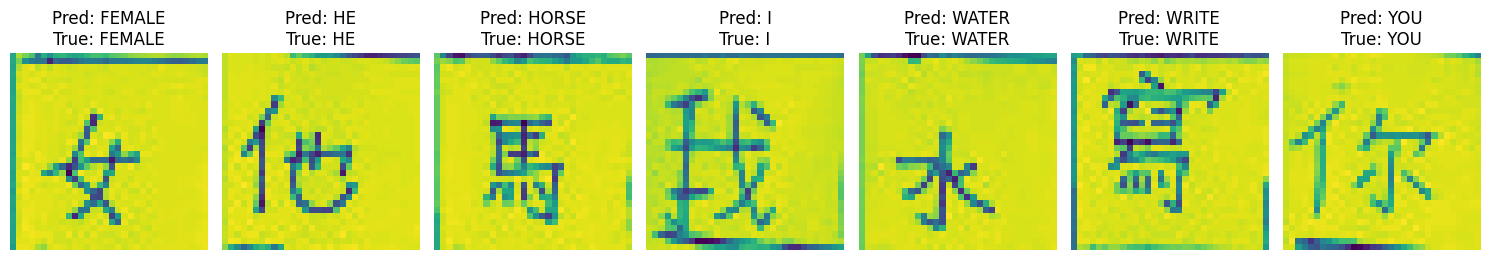

In [19]:
import matplotlib.pyplot as plt
model_name = config['training']['model_name']
in_size = config['training']['in_size']
in_channels = config['training']['in_channels']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kernel_size = config['training']['kernel_size']
n_classes = len(config['classes']['names'])
class_names = dataset_val.classes

def load_model(checkpoint_file):
    checkpoint_dir = config['paths']['checkpoint_dir']
    checkpoint_file_path = PROJECT_ROOT / checkpoint_dir / model_name / checkpoint_file
    checkpoint = torch.load(checkpoint_file_path)
    model = HanziConv(in_size=in_size, in_channels=in_channels, n_classes=n_classes, kernel_size=kernel_size)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model


def test_model(checkpoint_file):

    model = load_model(checkpoint_file)
    n_classes = len(config['classes']['names'])
    fig, axes = plt.subplots(1, n_classes, figsize=(15, 3))

    # Dictionary to store one sample per class
    samples_per_class = {}
    
    # Get one sample from each class
    for idx in range(len(dataset_val)):
        image, true_label = dataset_val[idx]
        if true_label not in samples_per_class:
            samples_per_class[true_label] = (image, true_label)
        if len(samples_per_class) == n_classes:
            break

    # Run inference and plot
    model.eval()

    for class_idx in range(n_classes):
        image, true_label = samples_per_class[class_idx]
        
        # Inference
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            pred_label = output.argmax(dim=1).item()
        
        # Plot
        axes[class_idx].imshow(image.permute(1, 2, 0).cpu())
        axes[class_idx].set_title(f'Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}')
        axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

test_model("best_model.pth")
    